In [133]:
import pandas as pd
import os
import re
import numpy as np
from pprint import pprint
import math

os.chdir(r"/home/miu/pros/acc/test/")
## 先打印出来看看
dfUp = pd.read_excel(r'A公司银行存款日记账20221-6.xlsx')
dfDown = pd.read_csv(r'A公司银行存款日记账20227-12.csv', encoding = "GBK")

## 这里为了避免前面的问题，重新拼接一个 DataFrame 进行数据分析
df = pd.concat([dfUp, dfDown], ignore_index = True)
df


,交易时间,交易金额,交易对象类型,交易摘要,交易方所在城市,交易银行
0,2022-05-22 05:56:00,7.411500e+04,中型企业,从供应商处收到预支付项,乌鲁木齐,中国银行
1,2022-04-09 21:34:00,8.648500e+11,中型企业,从广告主处收到广告投放费用,深圳,中国银行
2,2022-05-13 08:05:00,1.064070e+05,中型企业,从租客处收到违约金款项,青岛,中国银行
3,2022-03-31 09:52:00,1.312040e+05,中型企业,收到客户提前支付的货款定金,唐山,中国银行
4,2022-06-27 10:03:00,4.377000e+04,中型企业,收到客户向公司支付的相关服务费用,长沙,中国银行
...,...,...,...,...,...,...
10998,2022-11-22 21:57:00,2.082700e+05,中型企业,无具体说明,乌鲁木齐,建设银行
10999,2022-07-18 09:43:00,1.603030e+05,中型企业,无具体说明,乌鲁木齐,建设银行
11000,2022-10-05 09:23:00,2.020430e+05,中型企业,无具体说明,潍坊,建设银行
11001,2022-11-23 05:53:00,2.992720e+05,大型企业,无具体说明,广州,建设银行


In [134]:
ent = ["大型企业", "中型企业", "小微企业", "小微商户", "其他"]
enterprise = pd.api.types.CategoricalDtype(
    ent,
    ordered = True
)

df["交易对象类型"] = df["交易对象类型"].astype(enterprise)
df = df.sort_values(by = ['交易对象类型'], ignore_index = True)

df

,交易时间,交易金额,交易对象类型,交易摘要,交易方所在城市,交易银行
0,2022-02-01 23:04:00,-11401569.0,大型企业,无具体说明,武汉,建设银行
1,2022-06-18 20:19:00,-14723659.0,大型企业,支付给物流公司的运输费用,佛山,建设银行
2,2022-05-14 08:00:00,-21383880.0,大型企业,无具体说明,苏州,建设银行
3,2022-03-30 14:42:00,25931832.0,大型企业,无具体说明,苏州,建设银行
4,2022-04-11 20:10:00,28487245.0,大型企业,无具体说明,天津,建设银行
...,...,...,...,...,...,...
10998,2022-07-05 20:45:00,8595.0,小微商户,无具体说明,合肥,建设银行
10999,2022-01-27 08:34:00,284036.0,其他,无具体说明,汕头,建设银行
11000,2022-05-13 16:56:00,31803.0,NaN,收到客户向公司支付的保证金,扬州,中国银行
11001,2022-05-05 11:45:00,2834.0,NaN,从投资方处收到分红款项,佛山,中国银行


可以看出最后 3 个是无用信息，至少对于总体的数据分析并无太大帮助  
我们舍去最后 3 条记录

In [135]:
import matplotlib.pyplot as plt
df = df[0:11000]
df

,交易时间,交易金额,交易对象类型,交易摘要,交易方所在城市,交易银行
0,2022-02-01 23:04:00,-11401569.0,大型企业,无具体说明,武汉,建设银行
1,2022-06-18 20:19:00,-14723659.0,大型企业,支付给物流公司的运输费用,佛山,建设银行
2,2022-05-14 08:00:00,-21383880.0,大型企业,无具体说明,苏州,建设银行
3,2022-03-30 14:42:00,25931832.0,大型企业,无具体说明,苏州,建设银行
4,2022-04-11 20:10:00,28487245.0,大型企业,无具体说明,天津,建设银行
...,...,...,...,...,...,...
10995,2022-12-30 16:35:00,18236.0,小微商户,无具体说明,潍坊,建设银行
10996,2022-08-05 15:27:00,18725.0,小微商户,无具体说明,南京,建设银行
10997,2022-12-05 06:48:00,11940.0,小微商户,无具体说明,南京,建设银行
10998,2022-07-05 20:45:00,8595.0,小微商户,无具体说明,合肥,建设银行


接下来我们进行可视化处理  
(1) 查看企业的规模 (柱状图)  
(2) 查看交易金额大小的分布情况 (折线图)  

<BarContainer object of 5 artists>

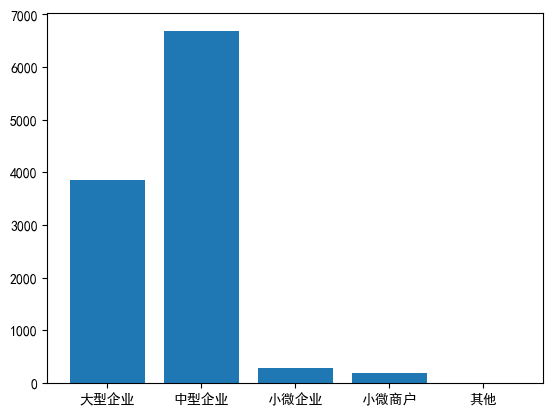

In [136]:
## 企业规模

scale = df[["交易对象类型"]].groupby(df["交易对象类型"], observed = True, dropna = True).count()
plt.bar(scale.index, scale["交易对象类型"])

**中大型企业交易量较多**

In [137]:
## 交易金额预处理

def sort_money(m):
    s = math.fabs(float(m))
    res = -1
        
    if (s >= 0):
        res += 1  # 小额
    if (s >= 10000):
        res += 1  # 万级
    if (s >= 100000):
        res += 1  # 十万级
    if (s >= 1000000):
        res += 1  # 百万级
    if (s >= 10000000):
        res += 1  # 千万级
    if (s > 100000000):
        res += 1  # 巨额
    
    return res

df = df[df["交易金额"].isna() == False]
df["scale"] = df["交易金额"].apply(sort_money)
dfMon = df[["scale"]].groupby(df["scale"]).count()
dfMon

/tmp/ipykernel_19425/2926463588.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["scale"] = df["交易金额"].apply(sort_money)


,scale
scale,
0,349
1,3765
2,3604
3,873
4,2403
5,3


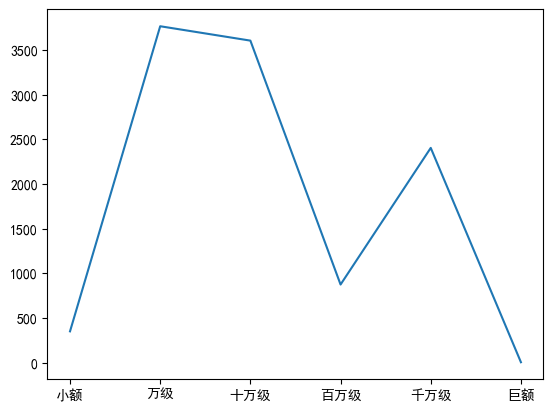

In [138]:
## 交易金额

plt.rcParams['font.sans-serif'] = ["SimHei"]
scale = ["小额", "万级", "十万级", "百万级", "千万级", "巨额"]
trueScale = range(0, 6)
plt.xticks(trueScale, scale)
plt.plot(dfMon)

**企业以万元级交易为主**